In [434]:
import os
import tensorflow as tf
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation,Dropout,Lambda,Dense,Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import EarlyStopping


from keras.utils.vis_utils import plot_model

In [435]:
# For Google Colab:
# from google.colab import drive
# drive.mount('/content/drive')

train_dir = './train/'
test_dir = './test/'
train_df = pd.read_csv('./train.csv')

In [436]:
# For Local File:
# train_dir = './train/'
# test_dir = './test/'
# train_df = pd.read_csv('./train.csv')

In [437]:
def plot_image(img):
    plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    plt.show()

def debug_dataAmounts():
  print("Train Data Amount : ", len(train_data))
  print("Train Category Amount : ", len(train_jenis))
  print("Train Colour Amount : ", len(train_warna))
  print("Test Data Amount : ", len(test_data))
  print("Test Ids Amount : ", len(test_ids))
  return

In [438]:
def basic_preProcess(img):
    img = resize_image(img)
    return img

def resize_image(img):
  image_size = (224,224)
  img = cv.resize(img, image_size,interpolation = cv.INTER_LINEAR)
  return img

In [439]:
def color_preProcess(img):
  #insert methods
  # img = to_colorhsv(img)
  # img = to_CIELAB(img)
  # img = to_CIEXYZ(img)
  # img = quantize_image(img,8)
  # img = to_RGB(img)


  return img

def to_colorhsv(img):

  hue_shift = 90
  saturation_scale = 1
  value_scale = 1

  img[..., 1] = np.clip(img[..., 1] * saturation_scale, 0, 255)
  img[..., 2] = np.clip(img[..., 2] * value_scale, 0, 255)
  img[..., 2] = cv.equalizeHist(img[..., 2])

  img = cv.cvtColor(img, cv.COLOR_HSV2BGR)

  return img

def to_CIELAB(img):
  img = cv.cvtColor(img,cv.COLOR_BGR2Lab)
  return img

def to_CIEXYZ(img):
  img = cv.cvtColor(img,cv.COLOR_BGR2XYZ)
  return img

def to_RGB(img):
  img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
  return img

def quantize_image(image, n_colors = 4):
    lab_image = cv.cvtColor(image, cv.COLOR_BGR2Lab)
    pixel_values = lab_image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(pixel_values)
    centers = kmeans.cluster_centers_
    quantized_pixels = centers[kmeans.predict(pixel_values)]
    quantized_image = quantized_pixels.reshape(lab_image.shape).astype(np.uint8)
    quantized_bgr_image = cv.cvtColor(quantized_image, cv.COLOR_Lab2RGB)

    return quantized_bgr_image


In [440]:
def category_preProcess(img):
  # img = to_grayhsv(img)
  img = gamma_correct_HSV(img)
  return img

def to_grayhsv(img):

  saturation_scale = 0
  value_scale = 0.1

  img[..., 1] = np.clip(img[..., 1] * saturation_scale, 0, 255)
  img[..., 2] = np.clip(img[..., 2] * value_scale, 0, 255)
  img[..., 2] = cv.equalizeHist(img[..., 2])


  img = cv.cvtColor(img, cv.COLOR_HSV2BGR)

  # img = cv.GaussianBlur(img,(5,5),0)

  return img

def gamma_correct_HSV(img):

  gamma = 2.0

  # hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  H, S, V = cv.split(img)

  lookup_table = np.array([((i / 255.0) ** (1.0 / gamma)) * 255 for i in np.arange(0, 256)]).astype("uint8")

  V_corrected = cv.LUT(V, lookup_table)
  corrected_hsv = cv.merge([H, S, V_corrected])
  corrected_image = cv.cvtColor(corrected_hsv, cv.COLOR_HSV2BGR)

  return corrected_image

In [441]:
train_data_color = []
train_data_category = []

train_jenis = []
train_warna =[]

test_data = []
test_ids = []

input_shape = (224, 224, 3)
for i in os.listdir(train_dir):
    if(i is not None):
        img_path = os.path.join(train_dir, i)
        img = cv.imread(img_path)
        if(img is not None):

          img = basic_preProcess(img)
          img_color = color_preProcess(img)
          img_category = category_preProcess(img)

          # plot_image(img_color)
          # break

          train_data_color.append(img_color)
          train_data_category.append(img_category)

          cond = train_df['id'] == int(i[:-4])
          idx = train_df.loc[cond].index[0]
          train_jenis.append(train_df.iloc[idx]['jenis'])
          train_warna.append(train_df.iloc[idx]['warna'])
        else:
          print("no image found")

for i in os.listdir(test_dir):
    if(i is not None):
      img_path = os.path.join(test_dir, i)
      img = cv.imread(img_path)
      if(img is not None):
        img = basic_preProcess(img)
        test_data.append(img)
        test_ids.append(i[:-4])
      else:
        print("no image found")

xtrain_warna, xval_warna, ytrain_warna, yval_warna = train_test_split(
    train_data_color, train_warna,
    test_size=0.2, random_state=42,
    stratify=train_warna  
)

xtrain_jenis, xval_jenis, ytrain_jenis, yval_jenis = train_test_split(
    train_data_category, train_jenis,
    test_size=0.2, random_state=42,
    stratify=train_jenis  
)

In [442]:
def ColorNet(input, nb_class):
    top_conv1 = Conv2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_conv1)

    # second top convolution layer
    # split feature map by half
    top_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(top_conv1)
    top_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(top_conv1)

    top_top_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv2)
    top_top_conv2 = BatchNormalization()(top_top_conv2)
    top_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv2)

    top_bot_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv2)
    top_bot_conv2 = BatchNormalization()(top_bot_conv2)
    top_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv2)

    # third top convolution layer
    # concat 2 feature map
    top_conv3 = Concatenate()([top_top_conv2,top_bot_conv2])
    top_conv3 = Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_conv3)

    # fourth top convolution layer
    # split feature map by half
    top_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(top_conv3)
    top_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(top_conv3)

    top_top_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_bot_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)

    # fifth top convolution layer
    top_top_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv5)

    top_bot_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)
    top_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv5)

    # ============================================= TOP BOTTOM ===================================================
    # first bottom convolution layer
    bottom_conv1 = Conv2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input)
    bottom_conv1 = BatchNormalization()(bottom_conv1)
    bottom_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_conv1)

    # second bottom convolution layer
    # split feature map by half
    bottom_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(bottom_conv1)
    bottom_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(bottom_conv1)

    bottom_top_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv2)
    bottom_top_conv2 = BatchNormalization()(bottom_top_conv2)
    bottom_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv2)

    bottom_bot_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv2)
    bottom_bot_conv2 = BatchNormalization()(bottom_bot_conv2)
    bottom_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv2)

    # third bottom convolution layer
    # concat 2 feature map
    bottom_conv3 = Concatenate()([bottom_top_conv2,bottom_bot_conv2])
    bottom_conv3 = Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_conv3)

    # fourth bottom convolution layer
    # split feature map by half
    bottom_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(bottom_conv3)
    bottom_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(bottom_conv3)

    bottom_top_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_bot_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)

    # fifth bottom convolution layer
    bottom_top_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv5)

    bottom_bot_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)
    bottom_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv5)

    # ======================================== CONCATENATE TOP AND BOTTOM BRANCH =================================
    conv_output = Concatenate()([top_top_conv5,top_bot_conv5,bottom_top_conv5,bottom_bot_conv5])

    flatten = Flatten()(conv_output)

    FC_1 = Dense(units=4096, activation='relu')(flatten)
    FC_1 = Dropout(0.7)(FC_1)
    FC_2 = Dense(units=4096, activation='relu')(FC_1)
    FC_2 = Dropout(0.7)(FC_2)
    output = Dense(units=nb_class)(FC_2)
    output = Activation("softmax")(output)

    return output

In [443]:
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,include_top=False,weights='imagenet')
base_model.trainable = False
# base_model.summary()

def create_model_warna(num_classes_warna):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Feature extraction layer
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    # Color branch
    color_output = layers.Dense(num_classes_warna, activation='softmax', name='color_output')(x)

    model = Model(inputs=base_model.input, outputs=color_output)
    return model

def create_model_jenis(num_classes_jenis):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Feature extraction layer
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    # Category branch
    category_output = layers.Dense(num_classes_jenis, activation='softmax', name='category_output')(x)

    model = Model(inputs=base_model.input, outputs=category_output)
    return model

In [444]:
input_shape = (224, 224, 3)

num_classes_jenis = len(np.unique(train_jenis))
num_classes_warna = len(np.unique(train_warna))

train_warna_categorical = to_categorical(train_warna, num_classes=num_classes_warna)
train_jenis_categorical = to_categorical(train_jenis, num_classes=num_classes_jenis)

ytrain_jenis = to_categorical(ytrain_jenis, num_classes=num_classes_jenis)
yval_jenis = to_categorical(yval_jenis, num_classes=num_classes_jenis)
ytrain_warna = to_categorical(ytrain_warna, num_classes=num_classes_warna)
yval_warna = to_categorical(yval_warna, num_classes=num_classes_warna)

xtrain_warna = np.array(xtrain_warna)
xval_warna = np.array(xval_warna)
xtrain_jenis = np.array(xtrain_jenis)
xval_jenis = np.array(xval_jenis)

inp_color = Input(shape=input_shape)
inp_category = Input(shape=input_shape)

colorBranch = ColorNet(input=inp_color, nb_class=num_classes_warna)

print("Color model categorical labels (train_warna_categorical):", train_warna_categorical)
print("Jenis model categorical labels (train_jenis_categorical):", train_jenis_categorical)


Color model categorical labels (train_warna_categorical): [[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
Jenis model categorical labels (train_jenis_categorical): [[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [445]:
# Model Instantiations
color_model = Model(inputs=inp_color,outputs=colorBranch)
plot_model(color_model, to_file="plot.png", show_shapes=True, show_layer_names = True)

# category_model = create_model_jenis(num_classes_jenis)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [446]:
# Train Color Model
opt = Adam(learning_rate=0.00001)
# early_stopping = EarlyStopping(monitor='val_loss', patience=5 restore_best_weights=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
color_model.compile(optimizer=opt, loss='categorical_crossentropy',
	metrics=['accuracy'])

history = color_model.fit(xtrain_warna,ytrain_warna, batch_size= 32, epochs=100,validation_data=(xval_warna,yval_warna))

Epoch 1/100
20/20 [==============================] - 2s 47ms/step - loss: 2.7478 - accuracy: 0.2721 - val_loss: 1.9455 - val_accuracy: 0.3013
Epoch 2/100
20/20 [==============================] - 1s 33ms/step - loss: 2.1597 - accuracy: 0.3108 - val_loss: 1.1667 - val_accuracy: 0.4615
Epoch 3/100
20/20 [==============================] - 1s 33ms/step - loss: 1.8080 - accuracy: 0.3833 - val_loss: 1.0676 - val_accuracy: 0.5128
Epoch 4/100
20/20 [==============================] - 1s 33ms/step - loss: 1.5762 - accuracy: 0.4541 - val_loss: 0.8777 - val_accuracy: 0.7821
Epoch 5/100
20/20 [==============================] - 1s 33ms/step - loss: 1.4064 - accuracy: 0.5121 - val_loss: 0.7660 - val_accuracy: 0.8590
Epoch 6/100
20/20 [==============================] - 1s 33ms/step - loss: 1.1937 - accuracy: 0.5604 - val_loss: 0.6743 - val_accuracy: 0.8718
Epoch 7/100
20/20 [==============================] - 1s 33ms/step - loss: 0.9444 - accuracy: 0.6618 - val_loss: 0.5813 - val_accuracy: 0.8846
Epoch 

KeyboardInterrupt: 

20/20 [==============================] - 0s 8ms/step - loss: 0.0961 - accuracy: 0.9662
Loss and metrics for each output: [0.09610407054424286, 0.966183602809906]
Total Test Loss: 0.09610407054424286
Color Accuracy: 0.966183602809906
5/5 [==============================] - 0s 8ms/step - loss: 0.2693 - accuracy: 0.9167
Loss and metrics for each output: [0.2693037986755371, 0.9166666865348816]
Total Vall Loss: 0.2693037986755371
Val Color Accuracy: 0.9166666865348816


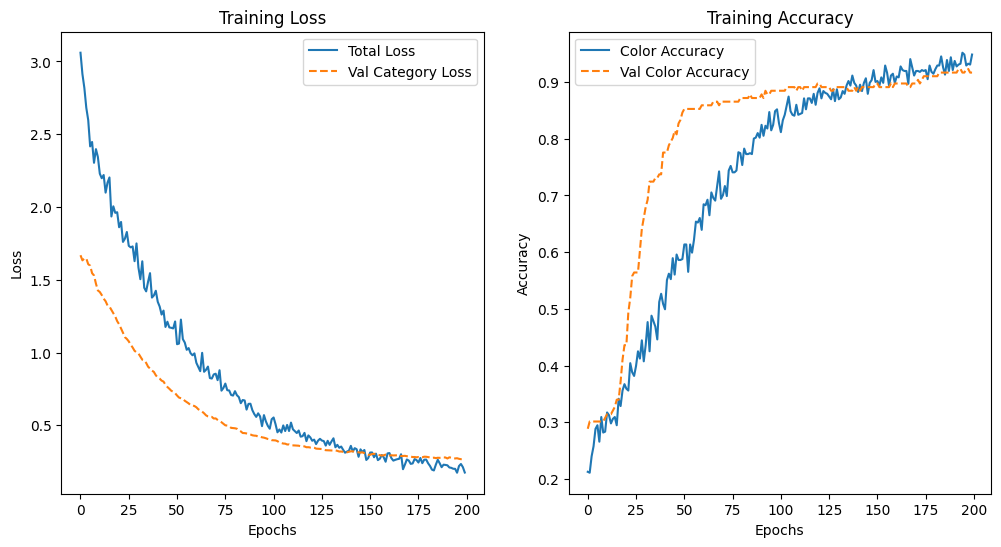

In [417]:
# View Color Model Metrics
score = color_model.evaluate(xtrain_warna,ytrain_warna)
print("Loss and metrics for each output:", score)
print('Total Test Loss:', score[0])
print('Color Accuracy:', score[1])

score = color_model.evaluate(xval_warna,yval_warna)
print("Loss and metrics for each output:", score)
print('Total Vall Loss:', score[0])
print('Val Color Accuracy:', score[1])

totall = len(history.history['loss'])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(totall), history.history['loss'], label='Total Loss')
plt.plot(range(totall), history.history['val_loss'], label='Val Category Loss', linestyle='--')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(totall), history.history['accuracy'], label='Color Accuracy')
plt.plot(range(totall), history.history['val_accuracy'], label='Val Color Accuracy', linestyle='--')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.show()

In [451]:
# Train Category Model
opt = Adam(learning_rate=0.001)

category_model.compile(optimizer=opt, loss='categorical_crossentropy',
	metrics=['accuracy'])

history = category_model.fit(xtrain_jenis,ytrain_jenis, batch_size= 32, epochs=60,validation_data=(xval_jenis,yval_jenis))

Epoch 1/60
20/20 [==============================] - 5s 155ms/step - loss: 3.1116e-07 - accuracy: 1.0000 - val_loss: 0.2149 - val_accuracy: 0.9615
Epoch 2/60
20/20 [==============================] - 3s 127ms/step - loss: 0.0817 - accuracy: 0.9887 - val_loss: 1.2536 - val_accuracy: 0.8910
Epoch 3/60
20/20 [==============================] - 2s 125ms/step - loss: 0.1682 - accuracy: 0.9469 - val_loss: 7.1926 - val_accuracy: 0.7628
Epoch 4/60
20/20 [==============================] - 2s 119ms/step - loss: 0.1162 - accuracy: 0.9614 - val_loss: 1.2851 - val_accuracy: 0.8333
Epoch 5/60
20/20 [==============================] - 2s 119ms/step - loss: 0.0908 - accuracy: 0.9758 - val_loss: 0.6278 - val_accuracy: 0.9295
Epoch 6/60
20/20 [==============================] - 2s 119ms/step - loss: 0.0439 - accuracy: 0.9887 - val_loss: 0.5945 - val_accuracy: 0.8974
Epoch 7/60
20/20 [==============================] - 2s 120ms/step - loss: 0.0228 - accuracy: 0.9936 - val_loss: 0.7469 - val_accuracy: 0.8526
Ep

KeyboardInterrupt: 

20/20 [==============================] - 1s 27ms/step - loss: 3.8393e-10 - accuracy: 1.0000
Loss and metrics for each output: [3.839268070127133e-10, 1.0]
Total Test Loss: 3.839268070127133e-10
Category Accuracy: 1.0
5/5 [==============================] - 0s 27ms/step - loss: 0.2374 - accuracy: 0.9551
Loss and metrics for each output: [0.2373623549938202, 0.9551281929016113]
Total Vall Loss: 0.2373623549938202
Val Category Accuracy: 0.9551281929016113


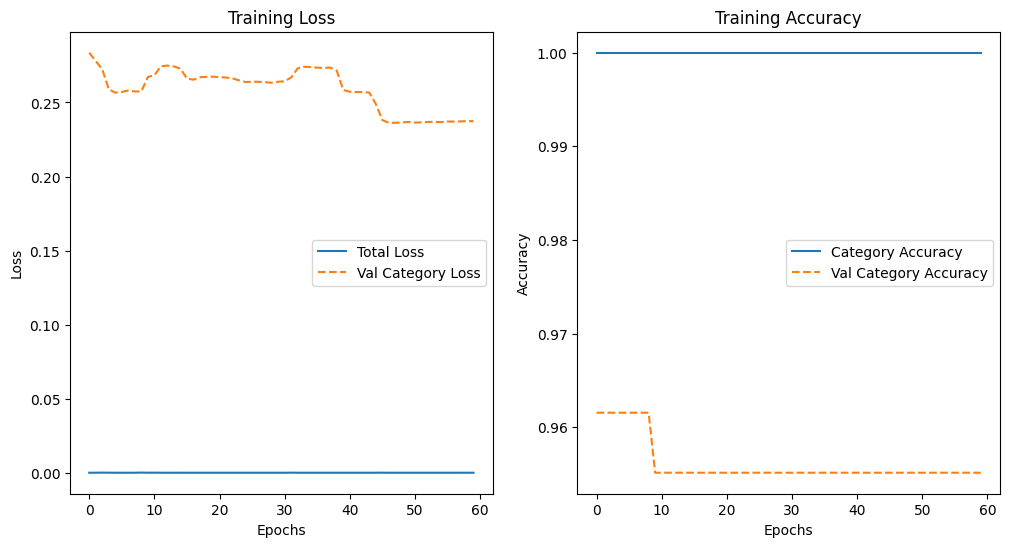

In [450]:
# View Category Model Metrics
score = category_model.evaluate(xtrain_jenis,ytrain_jenis)
print("Loss and metrics for each output:", score)
print('Total Test Loss:', score[0])
print('Category Accuracy:', score[1])

score = category_model.evaluate(xval_jenis,yval_jenis)
print("Loss and metrics for each output:", score)
print('Total Vall Loss:', score[0])
print('Val Category Accuracy:', score[1])

totall = len(history.history['loss'])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(totall), history.history['loss'], label='Total Loss')
plt.plot(range(totall), history.history['val_loss'], label='Val Category Loss', linestyle='--')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(totall), history.history['accuracy'], label='Category Accuracy')

plt.plot(range(totall), history.history['val_accuracy'], label='Val Category Accuracy', linestyle='--')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.show()

In [420]:
# Test results of Model and output as CSV
test_data = np.array(test_data)
prediction_jenis = category_model.predict(test_data)
prediction_warna = color_model.predict(test_data)

final_jenis = []
final_warna = []

for p_jenis, p_warna in zip(prediction_jenis,prediction_warna):
    final_jenis.append(np.argmax(p_jenis))
    final_warna.append(np.argmax(p_warna))
final = pd.DataFrame({'id':test_ids, 'jenis': final_jenis,'warna': final_warna})
final.to_csv('submission.csv', index=False)

11/11 [==============================] - 0s 7ms/step
